In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

In [3]:
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

In [4]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

In [5]:
Boston = load_data('Boston')
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

The Boston dataset records the median house value (medv) for 506 neighbourhoods around Boston, using 12 predictors such as **RM**, i.e. average number of rooms per dwelling, **age**, i.e. proportion of owner-occupied units built prior to 1940, and **lstat**, i.e. % of households with low socioeconomic status.

In [6]:
type(Boston)

pandas.core.frame.DataFrame

In [7]:
# Design matrix, augmented data --> a column of 1 to take into account the intercept/bias
X = pd.DataFrame({'intercept' : np.ones(Boston.shape[0]), 'lstat' : Boston['lstat']})
# Alternative definition as an array
# X = np.array([np.ones(Boston.shape[0]), Boston['lstat']]).T

In [8]:
y = Boston['medv']
# OLS specificies the model (Ordinary Least Squares) then model.fit() does the actual fitting
model = sm.OLS(y, X)
result = model.fit()
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: medv, Length: 506, dtype: float64

In [9]:
# Summarize produces a simple table of the parameter estimates, their standard errors, t-statistics and p-values
summarize(result)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


In [10]:
result.params

intercept    34.553841
lstat        -0.950049
dtype: float64

![pval_1.PNG](./pval_1.PNG)
![pval_2.PNG](./pval_2.PNG)

## Using sklearn

In [11]:
reg = linear_model.LinearRegression()
#Convert the DataFrame into an array
y_sk = np.array([Boston['medv']]).T
X_sk = np.array([np.ones(Boston.shape[0]), Boston['lstat']]).T
#X, y
reg.fit(X_sk, y_sk)
reg.coef_, reg.intercept_

(array([[ 0.        , -0.95004935]]), array([34.55384088]))

## Using fit and transform

Our model above has a single predictor, and constructing X was straightforward. In practice we often fit models with more than one predictor, typically selected from an array or data frame. We may wish to introduce transformations to the variables before fitting the model, specify interactions between variables, and expand some particular variables into sets of variables (e.g. polynomials). The sklearn package has a particular notion for this type of task: a *transform*. A transform is an object that is created with some parameters as arguments. The object has two main methods: fit() and transform().

We provide a general approach for specifying models and constructing the model matrix through the transform ModelSpec() in the ISLP library. ModelSpec() (renamed MS() in the preamble) creates a transform object, and then a pair of methods *transform()* and *fit()* are used to construct a corresponding model matrix.

We first describe this process for our simple regression model using a single predictor lstat in the Boston data frame, but we will use it repeatedly in more complex tasks in this and other labs in this book. In our case the transform is created by the expression design = MS(['lstat']). **The fit() method takes the original array and may do some initial computations on it, as specified in the transform object**. For example, it may compute means and standard deviations for centering and scaling. **The transform() method applies the fitted transformation to the array of data, and produces the model matrix**.

In [12]:
design = MS(['lstat'])
#Checks that the given variable exists in the Boston dataset
design = design.fit(Boston)
#Constructs the model matrix with two columns: an intercept and the variable lstat
X = design.transform(Boston)
X

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33
...,...,...
501,1.0,9.67
502,1.0,9.08
503,1.0,5.64
504,1.0,6.48


In [13]:
# Combines the the two previous operations into one
X = design.fit_transform(Boston)

## Making new predictions

The *get_prediction()* method can be used to obtain predictions, and produce confidence intervals and prediction intervals for the prediction of *medv* for given values of lstat.
We first create a new data frame, in this case containing only the variable lstat, with the values for this variable at which we wish to make predictions. We then use the transform() method of design to create the corresponding model matrix.

In [14]:
new_df = pd.DataFrame({'lstat':[5, 10, 15]})
newX = design.fit_transform(new_df)
newX

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [15]:
new_predictions = result.get_prediction(newX)
# Predicted mean simply computes the predicted value of y using the trained values of b and w and the newX
new_predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

In [16]:
# Computes the confidence intervals
new_predictions.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

In [17]:
# Computes the confidence intervals, which takes into account both the uncertainty of the mean and the variability of the individual data points --> wider range
new_predictions.conf_int(obs = True, alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

For instance, the 95% confidence interval associated with an lstat value of 10 is (24.47, 25.63), and the 95% prediction interval is (12.82, 37.28). As expected, the confidence and prediction intervals are centered around the same point (a predicted value of 25.05 for medv when lstat equals 10), but the latter are substantially wider.

## Plotting

In [18]:
def abline(ax, b, m, *args , **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim , ylim , *args , **kwargs)

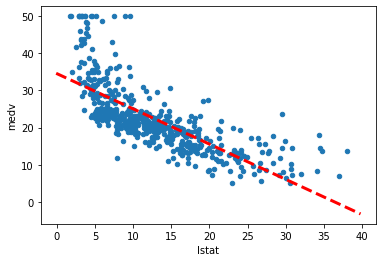

In [19]:
ax = Boston.plot.scatter('lstat', 'medv')
abline(ax, result.params.iloc[0], result.params.iloc[1], 'r--', linewidth = 3)

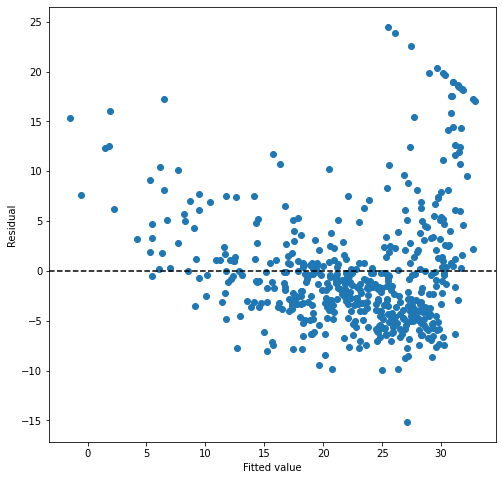

In [20]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(result.fittedvalues , result.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

Residual plots are a useful graphical tool for identifying non-linearity. Given a simple linear regression model, we can plot the residuals $y_i − \hat{y}_i$, versus the predictor $x_i$. In the case of a multiple regression model, since there are multiple predictors, we instead plot the residuals versus the predicted (or fitted) values $\hat{y}_i$. Ideally, the residual plot will show no discernible pattern. The presence of a pattern may indicate a problem with fitted some aspect of the linear model.

374

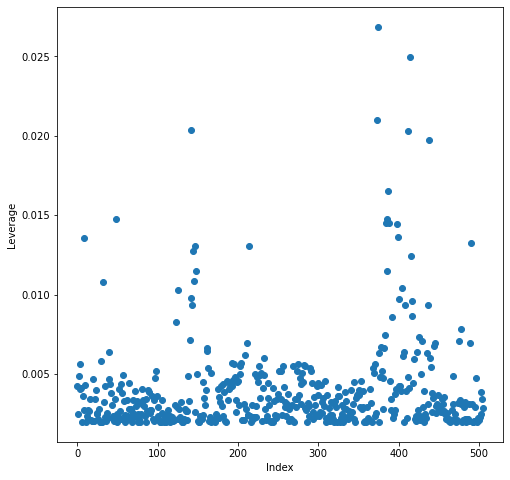

In [21]:
infl = result.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
#Leverage statistics can be computed for any number of predictors using the hat_matrix_diag attribute of the value returned by the get_influence() method.
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
# maximized over the entire array to determine which observation has the largest leverage statistic.
np.argmax(infl.hat_matrix_diag)

Observations with high leverage high have an unusual value for $x_i$ leverage. High leverage observations tend to have a sizable impact on the estimated regression line. It is cause for concern if the least squares line is heavily affected by just a couple of observations, because any problems with these points may invalidate the entire fit. For this reason, it is important to identify high leverage observations.

In [22]:
Boston.iloc[374]

crim        18.4982
zn           0.0000
indus       18.1000
chas         0.0000
nox          0.6680
rm           4.1380
age        100.0000
dis          1.1370
rad         24.0000
tax        666.0000
ptratio     20.2000
lstat       37.9700
medv        13.8000
Name: 374, dtype: float64

In [23]:
new_df = pd.DataFrame({'lstat':[37.97]})
newX = design.fit_transform(new_df)
new_predictions = result.get_prediction(newX)
# Predicted mean simply computes the predicted value of y using the trained values of b and w and the newX
new_predictions.predicted_mean

array([-1.51953308])

The predicted values is $-1.51953308$ while the actual *medv* value is $13.8$.

## Multiple linear regression

In order to fit a multiple linear regression model using least squares, we again use the *ModelSpec()* transform to construct the required model matrix and response. The arguments to ModelSpec() can be quite general, but in this case a list of column names suffice. We consider a fit here with the two variables lstat and age.

In [24]:
X = MS(['lstat', 'age']).fit_transform(Boston)
model1 = sm.OLS(y, X)
results1 = model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


In [25]:
#Just drop the y comlumn and retain all the independent variables
terms = Boston.columns.drop('medv')
X = MS(terms).fit_transform(Boston)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


What if we would like to perform a regression using all of the variables but one? For example, in the above regression output, age has a high p-value. So we may wish to run a regression excluding this predictor. The following syntax results in a regression using all predictors except age.

In [26]:
minus_age = Boston.columns.drop(['medv', 'age'])
Xma = MS(minus_age).fit_transform(Boston)
model1 = sm.OLS(y, Xma)
summarize(model1.fit())

,coef,std err,t,P>|t|
intercept,41.5251,4.920,8.441,0.000
crim,-0.1214,0.033,-3.683,0.000
zn,0.0465,0.014,3.379,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8528,0.868,3.287,0.001
nox,-18.4851,3.714,-4.978,0.000
rm,3.6811,0.411,8.951,0.000
dis,-1.5068,0.193,-7.825,0.000
rad,0.2879,0.067,4.322,0.000
tax,-0.0127,0.004,-3.333,0.001


## Collinearity

The presence of collinearity can pose problems in the regression context, since it can be difficult to separate out the individual effects of collinear variables on the response.
Consequently, collinearity results in a decline in the t-statistic. As a result, in the presence of collinearity, we may fail to reject H0 : $\beta_j$ = 0. This means that the power of the hypothesis test—the probability of correctly power detecting a non-zero coefficient is reduced by collinearity.

A good way to assess multi-collinearity is to compute the *variance inflation factor (VIF)*. The VIF is variance inflation factor the ratio of the variance of $\beta_j$ when fitting the full model divided by the variance of $\beta_j$ if fit on its own. The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. Typically in practice there is a small amount of collinearity among the predictors. As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity.

In [27]:
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals}, index=X.columns [1:])
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


The function *VIF()* takes two arguments: a dataframe or array, and a variable column index. In the code above we call VIF() on the fly for all columns in X. We have excluded column 0 above (the intercept), which is not of interest. In this case the VIFs are not that exciting.

## Non-linearity

In [28]:
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


The effectively zero p-value associated with the quadratic term (i.e. the third row above) suggests that it leads to an improved model. By default, *poly()* creates a basis matrix for inclusion in the model matrix whose columns are orthogonal polynomials, which are designed for stable least squares computations. Alternatively, had we included an argument *raw=True* in the above call to poly(), the basis matrix would consist simply of lstat and $lstat^2$. Since either of these bases represent quadratic polynomials, the fitted values would not change in this case, just the polynomial coefficients. Also by default, the columns created by poly() do not include an intercept column as that is automatically added by MS().

We use the *anova_lm()* function to further quantify the extent to which the quadratic fit is superior to the linear fit.

In [29]:
anova_lm(result , results3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,504.0,19472.381418,0.0,NaN,NaN,NaN
1,502.0,14165.613251,2.0,5306.768167,94.030437,2.069639e-35


Here result represents the linear submodel containing predictors lstat and age, while results3 corresponds to the larger model above with a quadratic term in lstat. The anova_lm() function performs a hypothesis test comparing the two models. The null hypothesis is that the quadratic term in the bigger model is not needed, and the alternative hypothesis is that the bigger model is superior. Here the F-statistic is 177.28 and the associated p-value is zero. In this case the F-statistic is the square of the
t-statistic for the quadratic term in the linear model summary for results3— a consequence of the fact that these nested models differ by one degree of freedom. This provides very clear evidence that the quadratic polynomial in lstat improves the linear model. This is not surprising, since earlier we saw evidence for non-linearity in the relationship between medv and lstat. The function anova_lm() can take more than two nested models as input, in which case it compares every successive pair of models. That also explains
why their are NaNs in the first row above, since there is no previous model with which to compare the first.